In [1]:
## -- IMPORTS --
import torch
import torch.nn as nn
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from dataset_util import BirdDataset
from torch.utils.data import DataLoader
from dataset_util import train_val_loaders


In [2]:
# load and clean paths
train_df = pd.read_csv("train_images.csv")

train_df["image_path"] = train_df["image_path"].str.lstrip("/")
train_df["image_path"] = train_df["image_path"].apply(lambda x: "train_images/" + x)
train_df["label_idx"] = train_df["label"] - 1

train_df.head()

,image_path,label,label_idx
0,train_images/train_images/1.jpg,1,0
1,train_images/train_images/2.jpg,1,0
2,train_images/train_images/3.jpg,1,0
3,train_images/train_images/4.jpg,1,0
4,train_images/train_images/5.jpg,1,0


In [3]:
# class distribution
num_classes = train_df["label_idx"].nunique()
print("Number of images:", len(train_df))
print("Number of classes:", num_classes)

train_df["label"].value_counts().head()

Number of images: 3926
Number of classes: 200


label
1     35
4     35
2     35
9     34
10    34
Name: count, dtype: int64

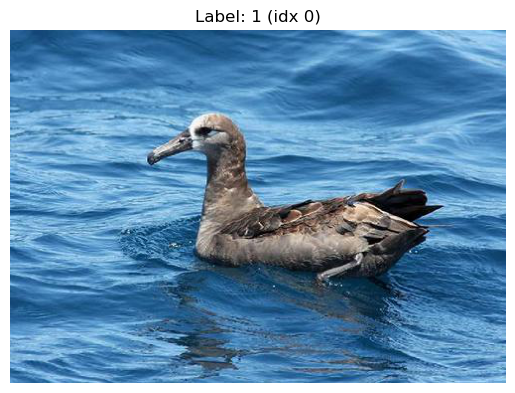

In [4]:
# see one bird
row0 = train_df.iloc[0]
img = Image.open(row0["image_path"]).convert("RGB")
plt.imshow(img)
plt.title(f"Label: {row0['label']} (idx {row0['label_idx']})")
plt.axis("off")
plt.show()

In [ ]:
batch_size = 64

train_loader, val_loader, train_df_split, val_df_split = train_val_loaders(
    train_df,
    img_size=(224, 224),
    batch_size=batch_size,
    val_size=0.2,
    random_state=42,
    num_workers=4,
    use_imagenet_norm=True,
    augment=True)

### Pipeline start

In [7]:
# Hyperparameters (placeholders)
embedding_dim = 128
batch_size = 64
lr = 1e-3
epochs = 25

In [24]:
# Model (placeholders)
from embedder_models import BirdEmbeddingModel
from multi_task_models import BirdMultiTaskModel
# from multi_input_models import BirdMultiInputModel

model = BirdEmbeddingModel()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cpu


In [25]:
# Training
for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        # forward pass
        logits = model(images)
        loss = criterion(logits, labels)

        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)
    
    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
        
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f}")
    
    # continue code...

KeyboardInterrupt: 

In [ ]:
# Test